In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import seaborn
import ast

In [ ]:
data=pd.read_csv('Hotel_Reviews_2.csv') #read the csv file

515738


## How the model works
This model is based on supervised learning: multiple data points with an associated target value (vector y) are observed. The model learns how to recognize new input (x) and predict the associated output (y) based on similar values (closest neighbours). K-nearest neighbors works well for this dataset. It is a simple algorithm to implement, easy to adapt to new training samples, and well-suited for this data size. The data is low-dimensional, which makes KNN perfect for this task. The low dimentional is making it possible to calculate the distance between the datapoints.

### Data
The data set "Hotel_Reviews" has over 500 000 data points which is a good foundation for modeltraining. It is a mix of values and text, so we have to preprocess this so the model can calculate our prediction. 

In this case, we chose to predict output y based on the 707 nearest neighbors. Choosing the number of neighbors k is important but challenging, as there is many correct answers.

A small k results in low bias and high variance (the model adapts instantly to noise).
A large k results in high bias and low variance (the model predicts values close to the mean).

The goal is to find a value of k that is the perfect balance between bias and variance, and gives the best performance.
Since this dataset contains over 500,000 data points, it is important to choose a k that is large enough to consider enough values when predicting y, but not so large that the model loses precision.

Often, it is conveniant to set k ≈ √n, where n is the number of data points. This gives k ≈ 707 in our case. We have also experimented with other values of k to find the perfect value to be used.


In [65]:
# This is the basic data cleaning process. This should be added in all the models
# This cell is a bit slow to run, so it is intended to be run only once

# This part drops the columns that are not needed in the model
data.drop('Hotel_Address',axis=1,inplace=True)  # Drop the column 'Hotel_Address' due to lack of relevance
data.drop('Review_Date',axis=1,inplace=True)    # Drop the column 'Review_Date' due to lack of complete data
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  # Drop the column 'Additional_Number_of_Scoring' due to not knowing what the numbers mean
data.drop('lat',axis=1,inplace=True)    # Drop the column 'lat' due to lack of relevance
data.drop('lng',axis=1,inplace=True)    # Drop the column 'lng' due to lack of relevance
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)    # Drop the column 'Total_Number_of_Reviews' due to the number seams to be incorrect


# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model



data.fillna(0, inplace=True)  # Replace Nan-values with 0

In [66]:
knn_data = data.copy()

knn_data.drop(['Negative_Review', 'Positive_Review'], axis=1, inplace=True) # In this model, these categories can not be used because the length of words that can not be converted to dummies.


# Label encode non-numerical features. LabelEncoder is neccesary for the Kernel to not crash due to data overload. This will happend when too many unique values are created when converting categorical values to continous values.
# Do this for all categories:
label_encoded_reviwer_nationality = LabelEncoder()
knn_data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(knn_data['Reviewer_Nationality'])

label_encoded_tag_0 = LabelEncoder()
knn_data['Tag_0'] = label_encoded_tag_0.fit_transform(knn_data['Tag_0'].astype(str))

label_encoded_tag_1 = LabelEncoder()
knn_data['Tag_1'] = label_encoded_tag_1.fit_transform(knn_data['Tag_1'].astype(str))

label_encoded_tag_2 = LabelEncoder()
knn_data['Tag_2'] = label_encoded_tag_2.fit_transform(knn_data['Tag_2'].astype(str))

label_encoded_tag_3 = LabelEncoder()
knn_data['Tag_3'] = label_encoded_tag_3.fit_transform(knn_data['Tag_3'].astype(str))

label_encoded_tag_4 = LabelEncoder()
knn_data['Tag_4'] = label_encoded_tag_4.fit_transform(knn_data['Tag_4'].astype(str))

label_encoded_tag_5 = LabelEncoder()
knn_data['Tag_5'] = label_encoded_tag_5.fit_transform(knn_data['Tag_5'].astype(str))

print(knn_data.head())



   Average_Score  Reviewer_Nationality  Review_Total_Negative_Word_Counts  \
0            7.7                   167                                397   
1            7.7                    98                                  0   
2            7.7                    14                                 42   
3            7.7                   214                                210   
4            7.7                   146                                140   

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                   

I chose to remove the categories "Negative_Review" and "Positive Review" because they are a string of text and therefore useless for this model. Removing these categories from the data set, makes the model running faster and easier to work with. 

Next, LabelEncoder is used to convert the categorical data to numbers.

In [ ]:
features = knn_data.columns.difference(['Average_Score'])  # Returns all data except Avrage Score, because this might be higly correlated to what we want to predict
scaler = MinMaxScaler()                                          
knn_data[features] = scaler.fit_transform(knn_data[features])  # Scale the columns from 0-1


X = knn_data.drop('Reviewer_Score', axis=1)     #Need to drop this column so the predited output is not the actual input
y = knn_data['Reviewer_Score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68) # Split the data in to train/test-set

knn = KNeighborsRegressor(n_neighbors=707)        # Use regression because the values are continuous
knn.fit(X_train, y_train)                      

y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)    #Distance from predicted value to actual value


print(f'Accuracy: {mse:.4f}')


KNN Modellens Nøyaktighet: 0.0384


We chose to remove the category "Average_Score" because this score might be highly correlated to the score we want to predict. If we not remove this category, we give the model all the input it needs to predict "Reviewer_score" and we allow the model to cheat. This gives us model that is too accurate, but not functional. We want the model to learn from all categories, and not based on an almost done result (score).

Scaling is important so all the values are equally weighted. Since this model is based on distance to the neightbours, we would have a wrong result if not.

The distance from predicted value to actual value is our mean squared error, and is used to measure accuracy of the model. Our model has a mse of 0.0384, which means that the model is suited for predicting data. 

<Axes: xlabel='Reviewer_Score'>

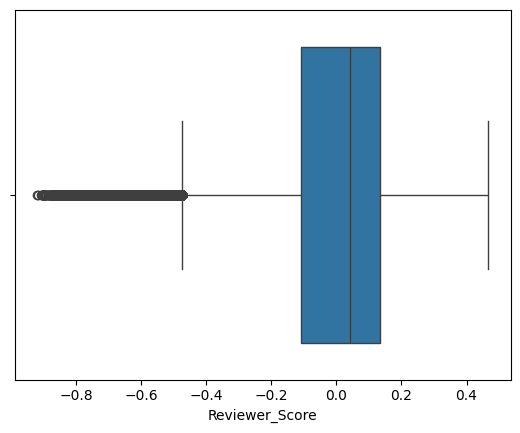

In [68]:
seaborn.boxplot(x=y_test-y_pred)